# 1. Calibration effects using diversity metric

In [3]:
import os
import sys
sys.path.append('../examples')
sys.path.append('../jobs')
sys.path.append('../training_data')

from tqdm import trange

import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
from generate_with_entropy import sample_sequence, sample_sequence_batch

import logging
logging.getLogger('transformers.tokenization_utils').setLevel(logging.ERROR)

In [4]:
# setup cell

def set_seed(seed=42, n_gpu=0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpus = torch.cuda.device_count()

set_seed()
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.to(device)
model.eval()

vocab_size = tokenizer.vocab_size

01/21/2020 23:01:07 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-config.json from cache at /u/myhu/.cache/torch/transformers/4be02c5697d91738003fb1685c9872f284166aa32e061576bbe6aaeb95649fcf.085d5f6a8e7812ea05ff0e6ed0645ab2e75d80387ad55c1ad9806ee70d272f80
01/21/2020 23:01:07 - INFO - transformers.configuration_utils -   Model config {
  "attn_pdrop": 0.1,
  "embd_pdrop": 0.1,
  "finetuning_task": null,
  "initializer_range": 0.02,
  "is_decoder": false,
  "layer_norm_epsilon": 1e-05,
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_layer": 12,
  "n_positions": 1024,
  "num_labels": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "resid_pdrop": 0.1,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "torchscript": false,
  "use_bf

In [5]:
# generation, no truncation

file = '../training_data/gbw/test/100_lines.txt'
# file = '../training_data/cats.txt'
length = 135

In [6]:
# full gen, take 2
# turned off gradients for entropy, imported other method to deal with combining batches.
k = 0

with torch.no_grad():
    avg_ents = torch.zeros((1, length), device=device)
    i = 0
    with open(file) as fp:
        for line in fp:
            context = tokenizer.encode(line)
            ents = sample_sequence_batch(
                model=model,
                context=context,
                length=length,
                tokenizer=tokenizer,
                temperature=0.968,
                top_k=k,
                top_p=0.0,
                batch_size=64,
                num_samples=128,
                is_xlnet=False,
                device=device
            )
            ents = ents.mean(axis=0)
            avg_ents = (avg_ents * i + ents) / (i + 1)
            i += 1

 89%|████████▉ | 120/135 [00:34<00:08,  1.80it/s]

RuntimeError: CUDA out of memory. Tried to allocate 2.41 GiB (GPU 0; 10.73 GiB total capacity; 4.73 GiB already allocated; 2.41 GiB free; 2.78 GiB cached)

In [7]:
ents_temp = avg_ents.cpu().numpy()

In [8]:
ents_temp

array([[3.9763484, 2.8690734, 4.245613 , 3.9395442, 3.7374408, 3.7373393,
        3.682041 , 3.65426  , 3.6674364, 3.6068285, 3.651591 , 3.673866 ,
        3.677447 , 3.6369781, 3.6043544, 3.6393406, 3.6918402, 3.5615673,
        3.5632386, 3.6424472, 3.5852213, 3.5942707, 3.59274  , 3.5904174,
        3.5728266, 3.5991132, 3.553972 , 3.5879288, 3.624536 , 3.6291075,
        3.5924103, 3.5809722, 3.6270597, 3.5969367, 3.595249 , 3.521351 ,
        3.5425892, 3.5562568, 3.5248077, 3.5615523, 3.6049914, 3.613414 ,
        3.5241385, 3.6188045, 3.6168149, 3.5322704, 3.59224  , 3.6110296,
        3.5882635, 3.514173 , 3.5673323, 3.5937796, 3.5581484, 3.6127536,
        3.5580506, 3.5482008, 3.5695822, 3.5910304, 3.5309558, 3.5938404,
        3.603749 , 3.5720317, 3.5956123, 3.599185 , 3.5986776, 3.5965505,
        3.6073499, 3.6621125, 3.542957 , 3.6608214, 3.5515912, 3.6253226,
        3.574823 , 3.6196544, 3.580857 , 3.581163 , 3.6379347, 3.612405 ,
        3.6300776, 3.6290476, 3.638515

In [ ]:
# full gen, take 2
# turned off gradients for entropy, imported other method to deal with combining batches.
k = 0

with torch.no_grad():
    avg_ents = torch.zeros((1, length), device=device)
    i = 0
    with open(file) as fp:
        for line in fp:
            context = tokenizer.encode(line)
            ents = sample_sequence_batch(
                model=model,
                context=context,
                length=length,
                tokenizer=tokenizer,
                temperature=1,
                top_k=k,
                top_p=0.0,
                batch_size=32,
                num_samples=128,
                is_xlnet=False,
                device=device
            )
            ents = ents.mean(axis=0)
            avg_ents = (avg_ents * i + ents) / (i + 1)
            i += 1

In [15]:
ents_full = avg_ents.cpu().numpy()

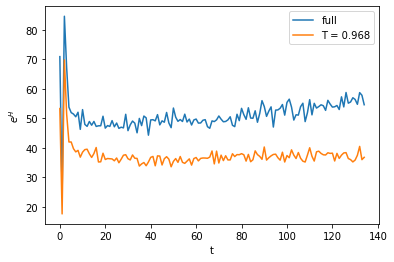

In [18]:
plt.plot(np.exp(ents_full[0, :]), label='full')
plt.plot(np.exp(ents_temp[0, :]), label='T = 0.968')
plt.xlabel('t')
plt.ylabel('$e^H$')
plt.legend()